# Recurrent Neural Networks for Time Series Forecasting: LTSM, GRU, Vanilla

In [1]:
!pip install darts

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 117.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 13.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata 

In [2]:
EPOCH = 10        # for testing or debugging, rather than real forecasts, 
                  # set EPOCH to a low value like 3; for the real deal: 300 
                  # 300 will take as much as 30 - 50 minutes of processing time

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import TimeSeries
from darts.datasets import SunspotsDataset, AirPassengersDataset
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from darts.utils.timeseries_generation import datetime_attribute_timeseries


import math
import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 36               # forecast periods
FC_START = "20220101"   # period at which to split training and validation dataset


# Prepare the Source Data

In [4]:
## load data
df = pd.read_csv('DataSheet_VentasUJ.csv')
df1 = pd.read_csv('DataSheet_VentasUJ.csv')
#df['VentaMXN'] = np.log10( df['VentaMXN'])
df['Fecha'] = df['Fecha'].astype('string')

df['Fecha'] = pd.to_datetime(df['Fecha'],format='%Y-%m-%d')

#col = df.pop("Fecha")
#df.insert(0,"Fecha",col)
series = TimeSeries.from_dataframe(df,'Fecha','VentaMXN',fill_missing_dates=True, freq="MS")
ts = series

In [5]:
#series.describe()

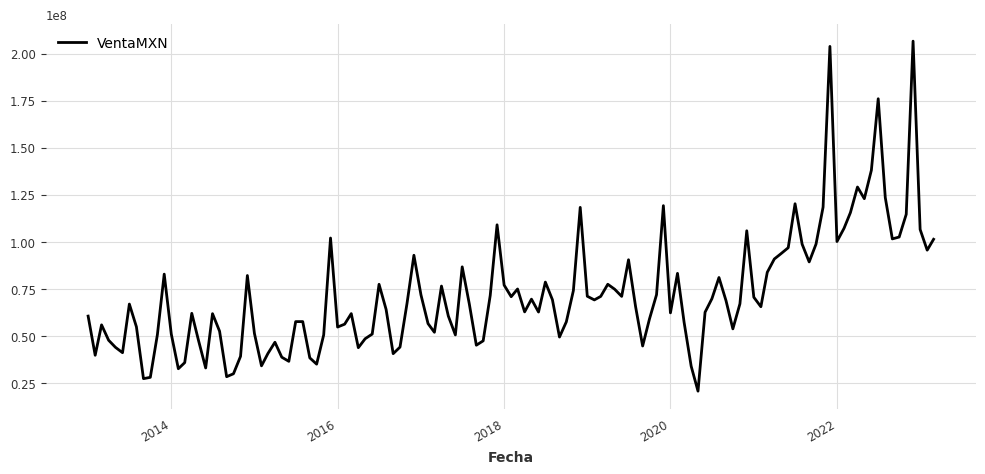

In [6]:
# plot the observations
plt.figure(100, figsize=(12, 5))
series.plot()

In [7]:
# analyze its seasonality and test distribution 

is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 5.0
periodicity (~years) : 0.4


In [8]:
# check distribution via Shapiro wilk test
shapiro(df1)

ShapiroResult(statistic=0.767275869846344, pvalue=2.2051855512936387e-18)

In [9]:
df1 = pd.read_csv("DataSheet_VentasUJ.csv")
df1['Fecha'] = df1['Fecha'].astype(int)
df1['Fecha'] = df1['Fecha'].astype(str)
df1['Fecha'] =  pd.to_datetime(df1['Fecha'], format='%Y-%m-%d')
df1 = df1.set_index('Fecha')
df1

,VentaMXN
Fecha,
2013-01-01,6.068329e+07
2013-02-01,3.988441e+07
2013-03-01,5.601737e+07
2013-04-01,4.785368e+07
2013-05-01,4.409887e+07
...,...
2022-11-01,1.147581e+08
2022-12-01,2.066904e+08
2023-01-01,1.066876e+08


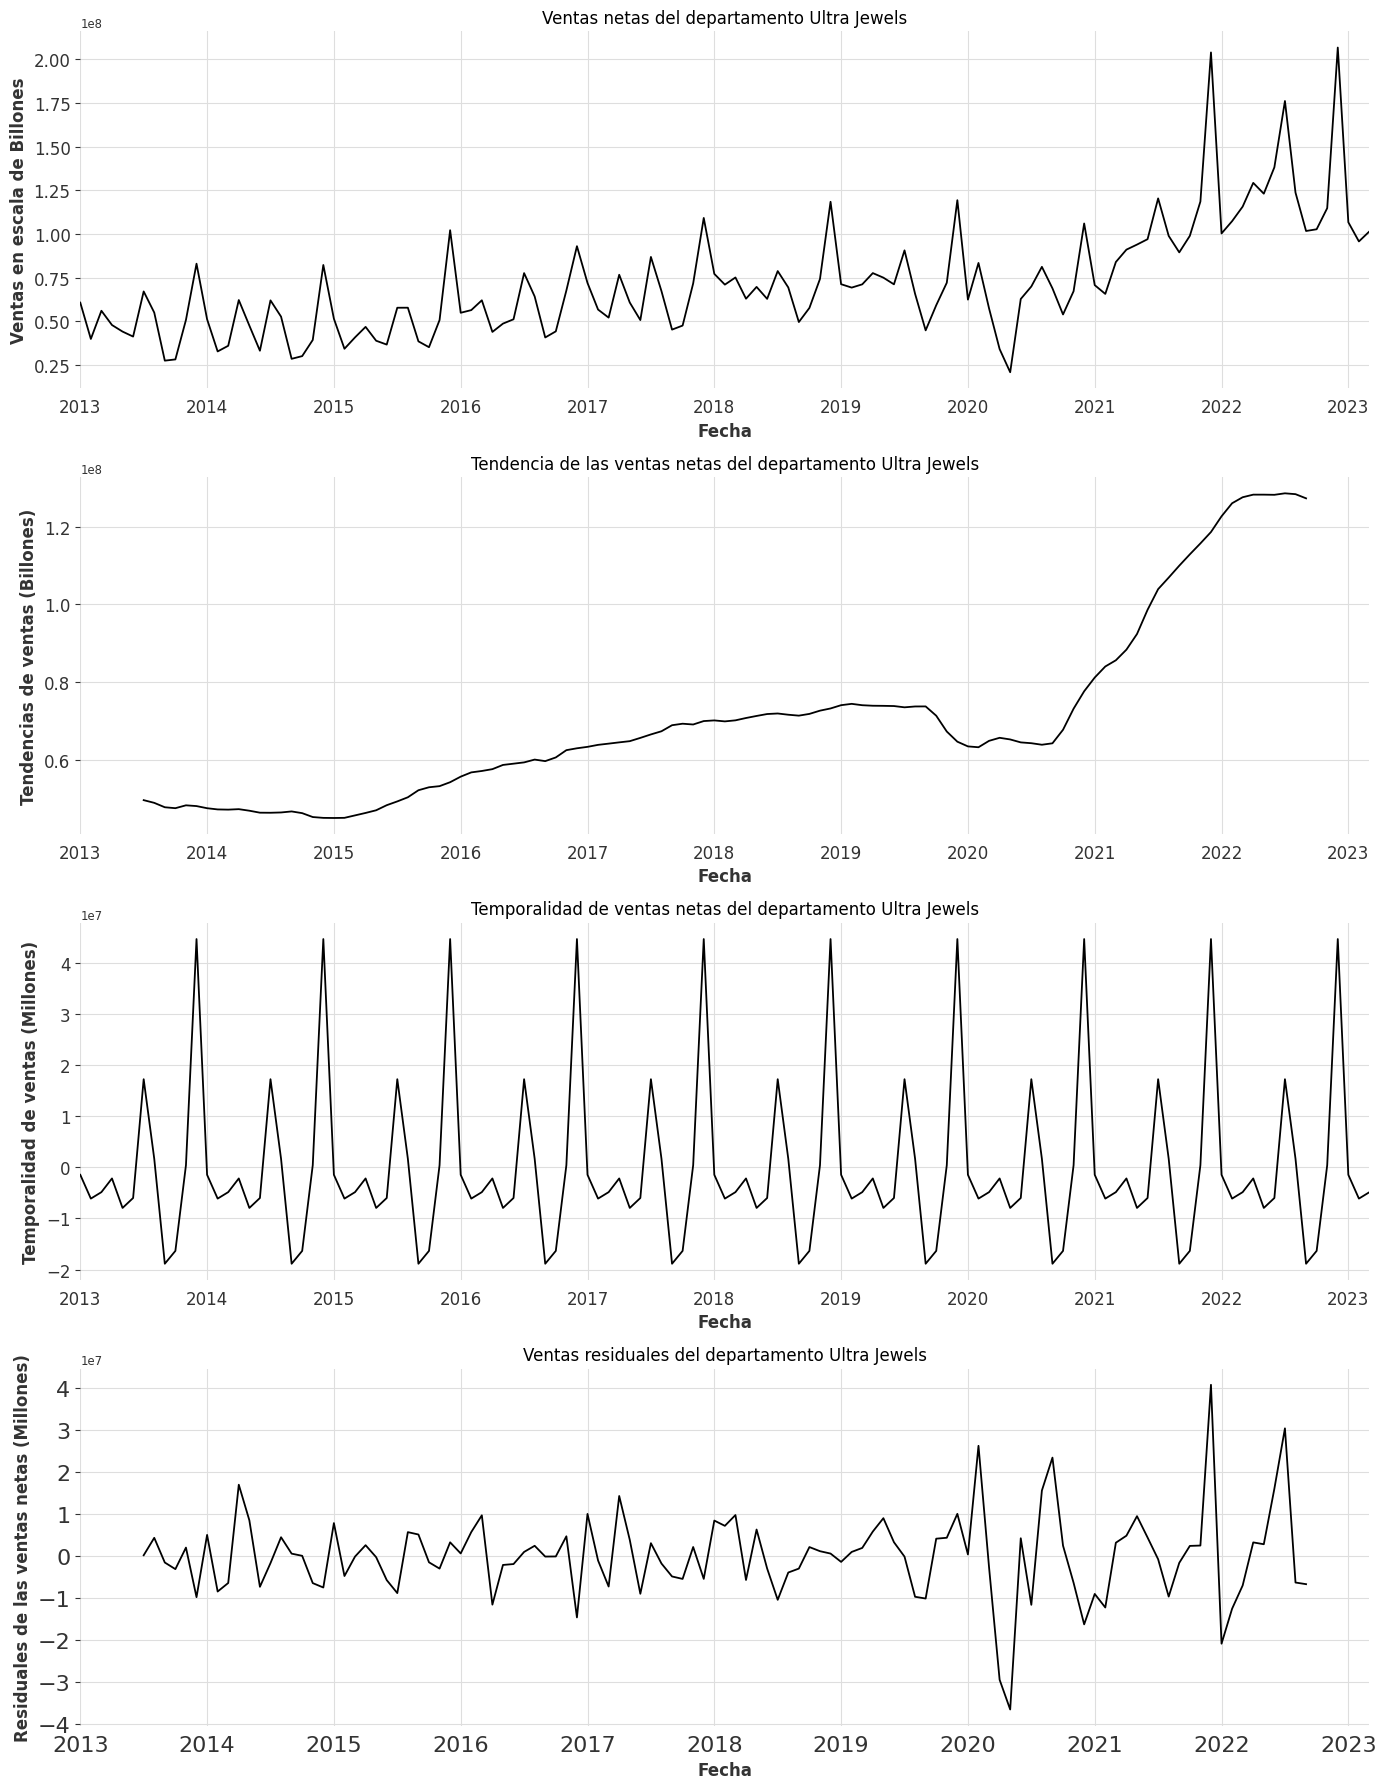

In [10]:



result = seasonal_decompose(df1['VentaMXN'],model='additive')

observed = result.observed
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# plot the individual components
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14,18))


observed.plot(ax=axes[0],title='Ventas netas del departamento Ultra Jewels',fontsize=12)
axes[0].set_ylabel('Ventas en escala de Billones',fontsize=12)
axes[0].set_xlabel('Fecha',fontsize=12)


trend.plot(ax=axes[1],title='Tendencia de las ventas netas del departamento Ultra Jewels',fontsize=12)
axes[1].set_ylabel('Tendencias de ventas (Billones)',fontsize=12)
axes[1].set_xlabel('Fecha',fontsize=12)

seasonal.plot(ax=axes[2],title='Temporalidad de ventas netas del departamento Ultra Jewels',fontsize=12)
axes[2].set_ylabel('Temporalidad de ventas (Millones)',fontsize=12)
axes[2].set_xlabel('Fecha',fontsize=12)


residual.plot(ax=axes[3],title='Ventas residuales del departamento Ultra Jewels',fontsize=16)
axes[3].set_ylabel('Residuales de las ventas netas (Millones)',fontsize=12)
axes[3].set_xlabel('Fecha',fontsize=12)

plt.tight_layout()
plt.show()


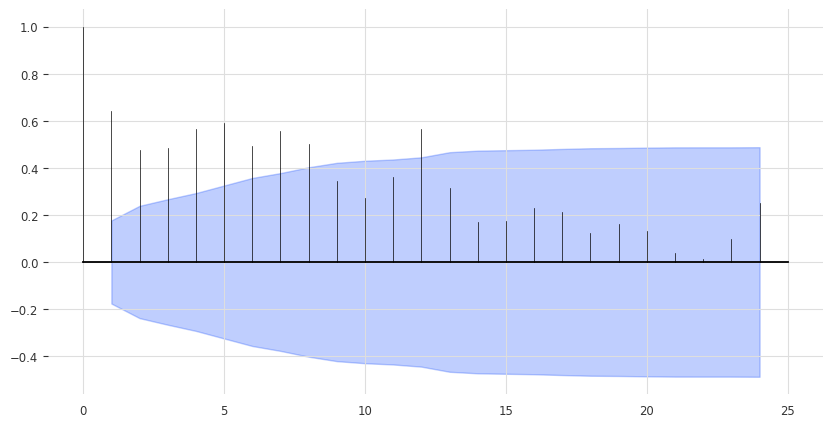

In [11]:
# plot its autocorrelation function
plot_acf(ts)

In [12]:
# split training vs test dataset
train, val = ts.split_after(pd.Timestamp(FC_START))

In [13]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [14]:
# create month and year covariate series

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

# Run the RNN Models

In [15]:
# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [16]:
# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

In [17]:
# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy

In [18]:
# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, ts, train, val):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=5,
        training_length=8,
        hidden_dim=8,
        n_rnn_layers=2,
        batch_size=18,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=1,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]
    


beginning the training of the LSTM RNN:


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

training of the LSTM RNN has completed: 2.97 sec


Predicting: 0it [00:00, ?it/s]

LSTM : 
MAPE : 832.3515
RMSPE : 1.1489
RMSE : 0.6651
-R squared : 10660.9324
se : 0.4058

beginning the training of the GRU RNN:


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

training of the GRU RNN has completed: 2.55 sec


Predicting: 0it [00:00, ?it/s]

GRU : 
MAPE : 68.9072
RMSPE : 0.3968
RMSE : 0.2817
-R squared : 279.0780
se : 0.4025

beginning the training of the Vanilla RNN:


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

training of the Vanilla RNN has completed: 1.86 sec


Predicting: 0it [00:00, ?it/s]

Vanilla : 
MAPE : 135.8652
RMSPE : 0.5488
RMSE : 0.3633
-R squared : 118.1046
se : 0.4165


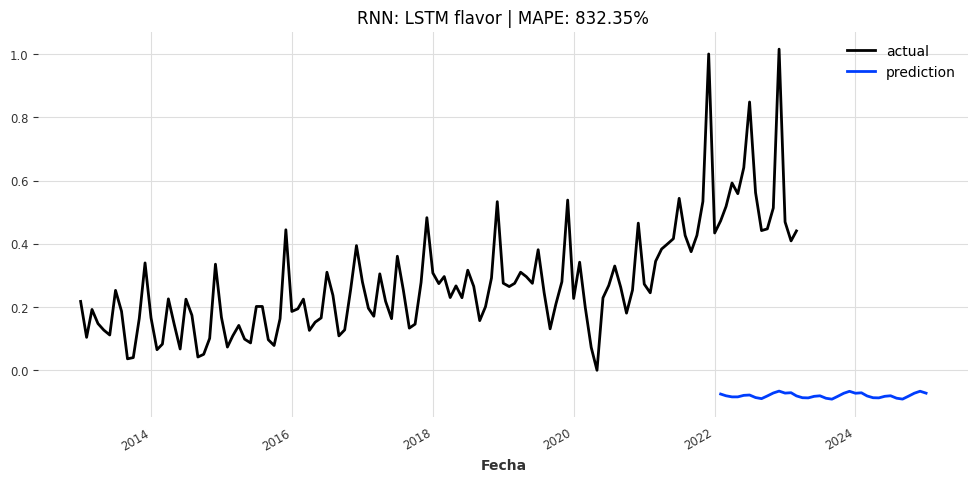

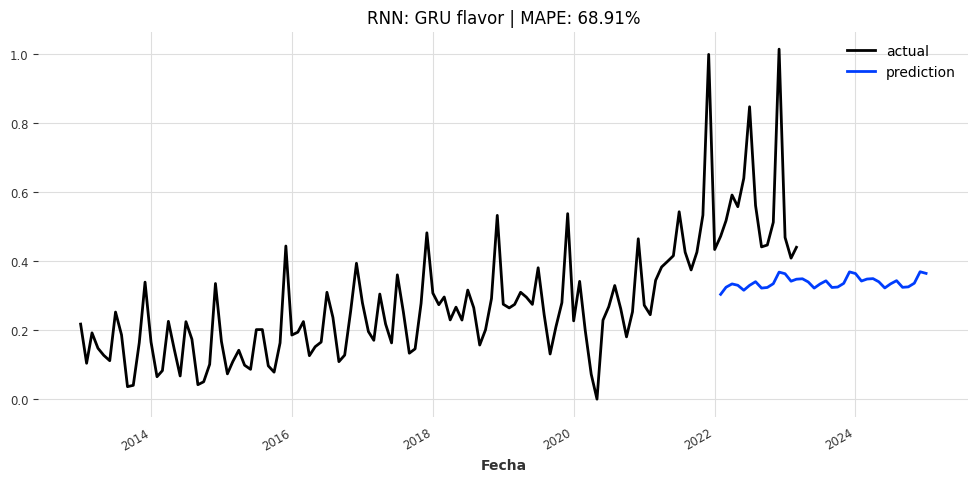

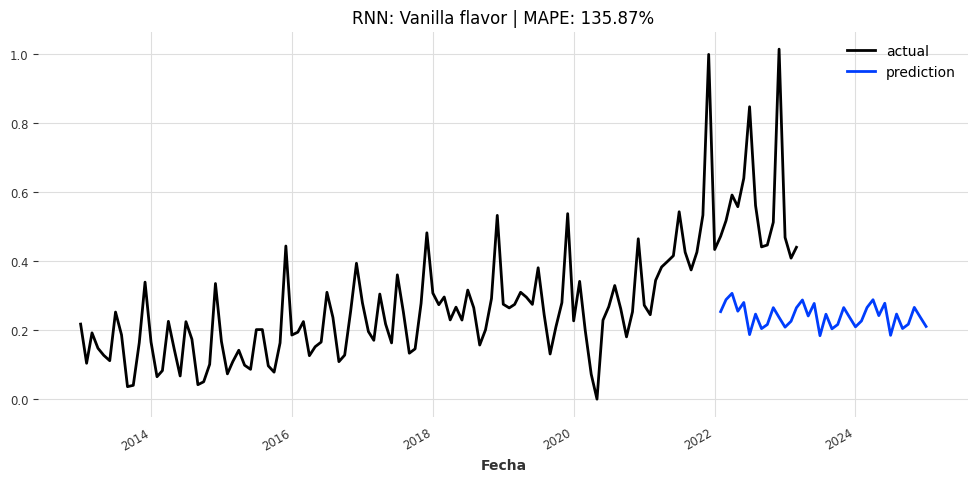

In [19]:
# run 3 different flavors of RNN on the time series:
flavors = ["LSTM", "GRU", "RNN"]

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]

# Compare with the Theta method

Theta forecast has completed:  1.96 sec
MAPE : 19.7740
RMSPE : 0.1986
RMSE : 35473046.4808
-R squared : 62.3077
se : 8786734.4395


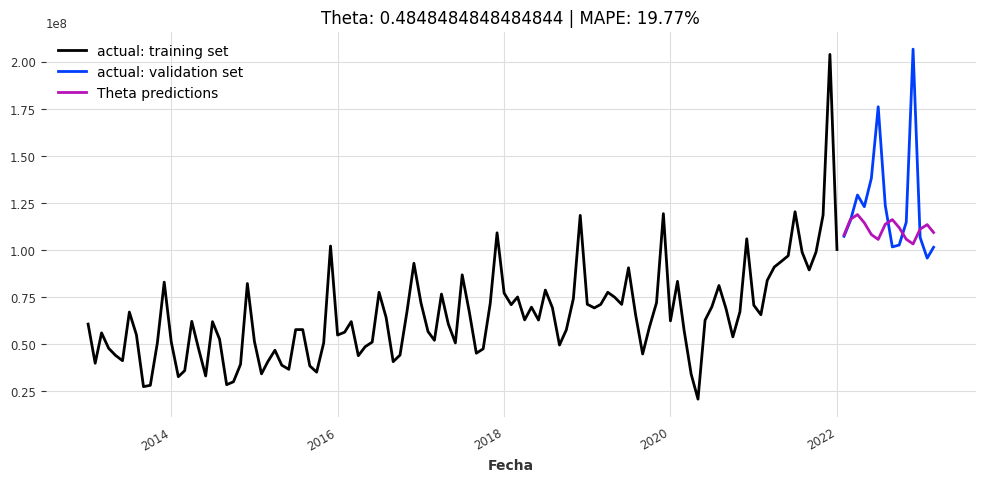

In [20]:
# Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
t_start =  time.perf_counter()
# search for best theta among 100 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)
    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta


# fit the model
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred = best_theta_model.predict(len(val))

# review the Theta results
plt.figure(figsize=(12,5))
train.plot(label='actual: training set')
val.plot(label='actual: validation set')
pred.plot(label='Theta predictions')
plt.title("Theta: {0}".format(best_theta) + ' | MAPE: {:.2f}%'.format(mape(pred, val)))
plt.legend();

res_time = time.perf_counter() - t_start
res_acc = accuracy_metrics(pred, val)
print("Theta forecast has completed: ", f'{res_time:.2f} sec')
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]
results = [pred, res_acc]


In [21]:
# collect the forecasters's accuracy metrics in a dataframe

dict_models = {"LSTM":res_flavors[0][1], "GRU":res_flavors[1][1],
    "Vanilla":res_flavors[2][1], "Theta":res_acc}
df_acc = pd.DataFrame.from_dict(dict_models, orient="index").T
pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,LSTM,GRU,Vanilla,Theta
MAPE,832.351468,68.907191,135.865178,19.773979
RMSPE,1.148932,0.396814,0.548764,0.198603
RMSE,0.665074,0.281675,0.363300,35473046.480787
-R squared,10660.932387,279.078010,118.104634,62.307689
se,0.405822,0.402490,0.416503,8786734.439481
